# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import cv2

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = np.array(train['features'], np.uint8), np.array(train['labels'])
X_valid_raw, y_valid_raw = np.array(valid['features'], np.uint8), np.array(valid['labels'])
X_test_raw, y_test_raw = np.array(test['features'], np.uint8), np.array(test['labels'])



## Step 1: Dataset Summary & Exploration

The data that was just loaded is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [2]:
# Number of training examples
n_train = len(y_train_raw)

# Number of validation examples
n_valid = len(y_valid_raw)

# Number of testing examples.
n_test = len(y_test_raw)

# What's the shape of an traffic sign image?
img_shp = X_train_raw[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_class = max(y_train_raw)+1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shp)
print("Number of classes =", n_class)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visual Exploration

In [3]:
# Plotting utilities

import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


def hist_plot(y):
    plt.hist(y, n_class);
    plt.xlabel('Class');
    plt.ylabel('Number of Images');
    ax = plt.gca();
    ax.grid(True)
    plt.show();


def plot_imgs(X, y=np.array([]), cols = 6, cmap='brg'):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    plotNum = 1
    plt.figure(figsize = (20, num_rows*4))
    for i in range(num_plots):
        
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(X[i], cmap=cmap)
        if(y.size > 0):
            plt.title("Label: " + str(y[i]))
        plotNum = plotNum + 1


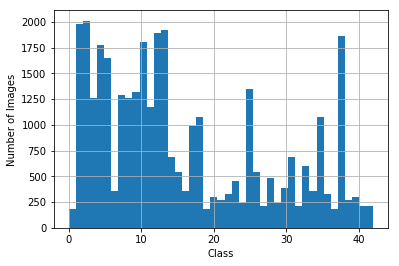

In [4]:
# Histogram of data

hist_plot(y_train_raw)


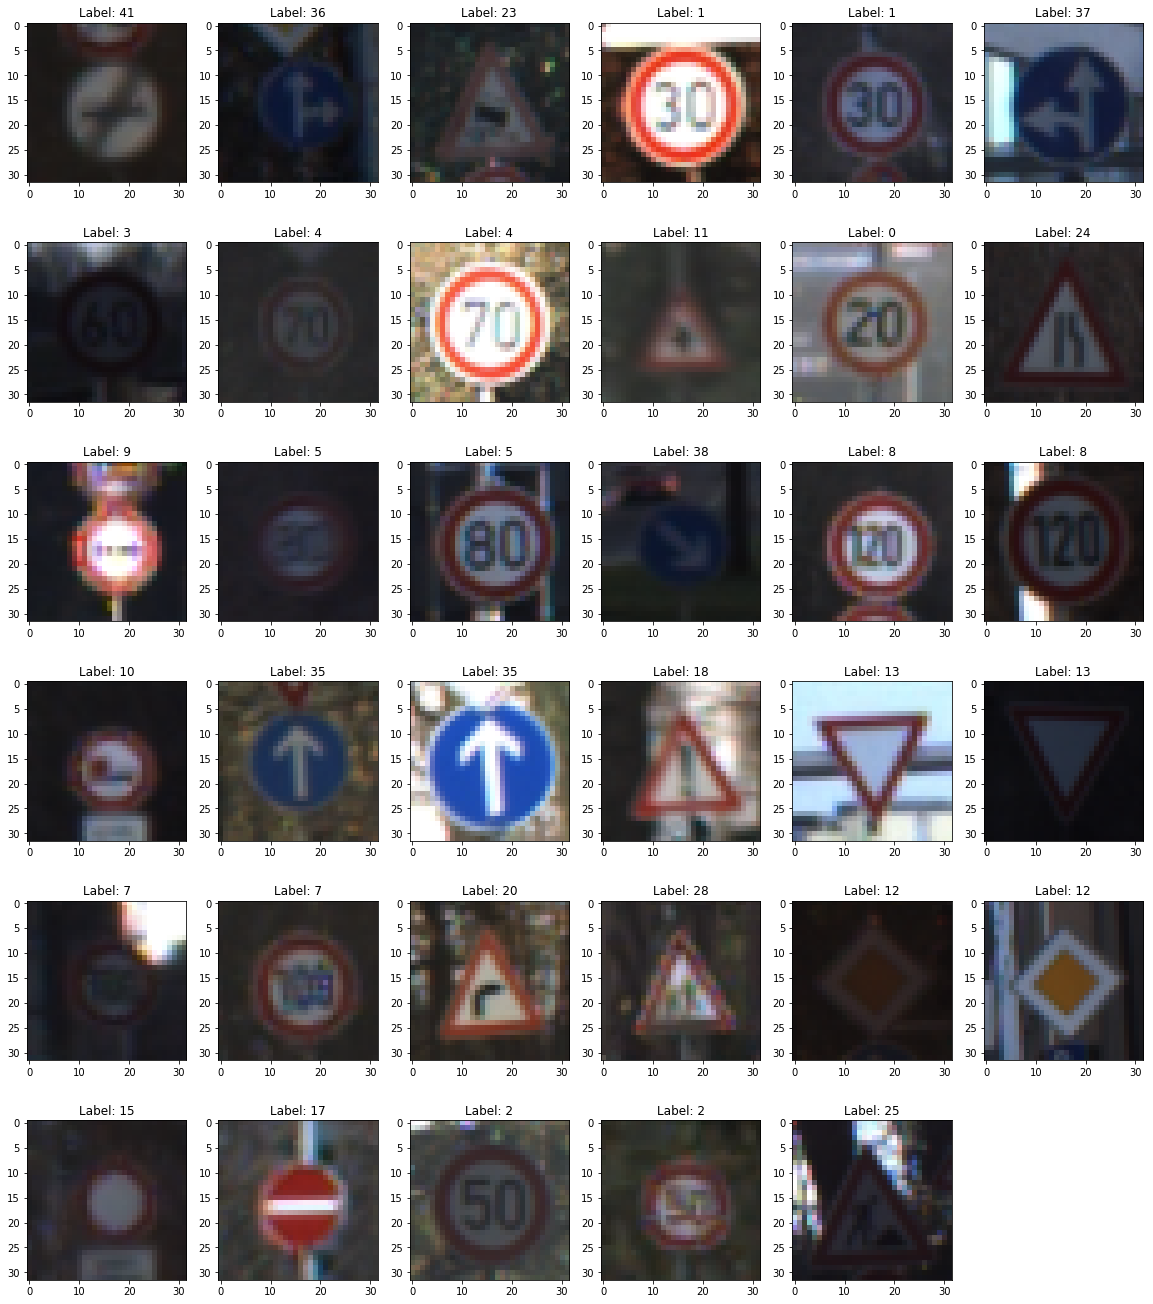

In [5]:
## Example images from dataset

test_img_labels = np.arange(0, n_train, 1000)
test_imgs = X_train_raw[test_img_labels]

plot_imgs(X_train_raw[test_img_labels], y_train_raw[test_img_labels])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

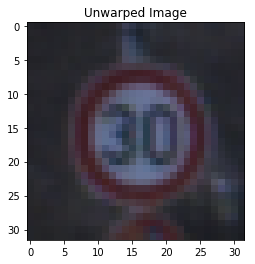

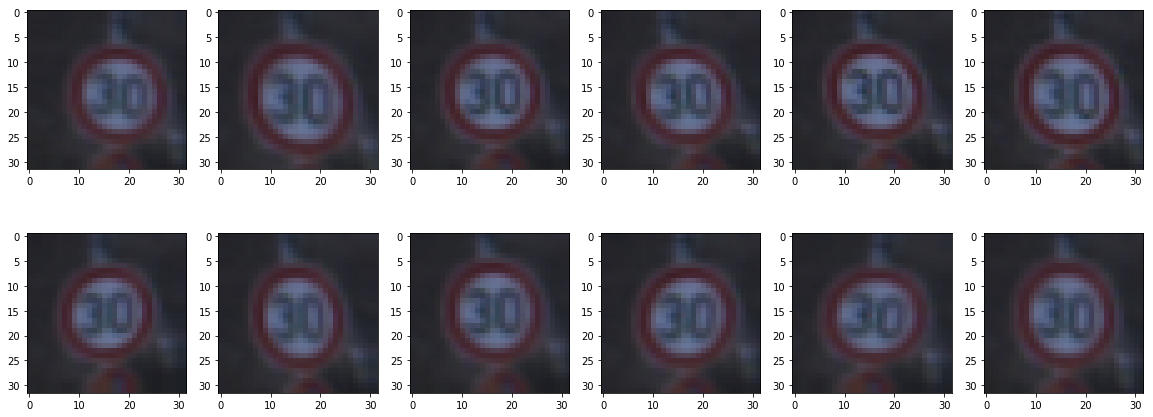

In [6]:
# Img warping pipeline

def warp_img(X):
    
    rotate = 12
    warp = 1.8
    
    size = img_shp[0]

    # Rotation
    M = cv2.getRotationMatrix2D((size/2,size/2), (np.random.random(1)-0.5)*rotate, 1)
    X = cv2.warpAffine(X, M, dsize=(size,size), borderMode= cv2.BORDER_REPLICATE)
    
    
    # Affine Warping
    p_src = np.float32([[warp,warp], [warp, 32-warp], [32-warp, warp]])
    p_dst = np.copy(p_src)

    for i in range(len(p_dst)):
        p_dst[i] = p_dst[i] + (np.random.random(2)-0.5)*2.0*warp
    
    M = cv2.getAffineTransform(p_src, p_dst)
    X = cv2.warpAffine(X, M, dsize=(size,size), borderMode= cv2.BORDER_REPLICATE)
    
    # Blurring
    blur = np.random.choice([1,3])
    X = cv2.GaussianBlur(X, ksize=(blur,blur), sigmaX = 0.4, sigmaY = 0.4)

    return X


# Quick test and visualization of warping agorithm
test_img = X_train_raw[4000]

plt.figure()
plt.title('Unwarped Image')
plt.imshow(test_img)

warped_imgs= np.empty([12,test_img.shape[0], test_img.shape[0], 3], dtype=test_img.dtype)
for i in range(12):
    warped_imgs[i] = warp_img(test_img)

                              
plot_imgs(warped_imgs)


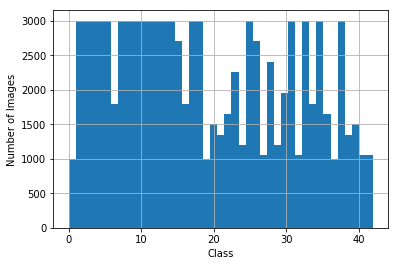

In [7]:
# Augment data set

def suppl_img(X, y):

    hist, edges = np.histogram(y, bins=n_class)
    
    X_new = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=X.dtype)
    y_new = np.empty([0], dtype = y.dtype)
    
    for i in range(n_class):
        
        num_imgs = hist[i]
        
        # Minimum of 1000 images, max of 3000.
        min_imgs = np.maximum(num_imgs*5, 1000)
        min_imgs = np.minimum(min_imgs, 3000)
        print("Number of images in class ", i, ": ", num_imgs)
        
        if num_imgs < min_imgs:
            label = i
            imgs = X[y == label]
            
            num_new = min_imgs - num_imgs
            print("Number of new images for class", i, ":", num_new)
            
            for j in range(num_new):
                # Pick a random image from the class
                rand_num = np.random.randint(0,num_imgs)
                rand_img = imgs[np.random.randint(0,num_imgs)]
                
                # Apply warping function
                rand_img = warp_img(rand_img)
                
                # Reshape for append
                rand_img = np.reshape(rand_img, (1,32,32,3))
                
                # Append to new images
                X_new = np.append(X_new, rand_img, axis = 0)
                y_new = np.append(y_new, [label], axis = 0)
   
    ## Final image set
    X = np.append(X, X_new, axis = 0)
    y = np.append(y, y_new, axis = 0)
    return (X, y)



# Choose to generate images, load images from file, or skip image generation (i.e.: use baseline image set)
src = "load"

X_save = 'X_train_suppl.p'
y_save = 'y_train_suppl.p'

if(src == "gen"):
    X_train_aug, y_train_aug = suppl_img(X_train_raw, y_train_raw)
    pickle.dump(X_train_aug, open( X_save, "wb" ))
    pickle.dump(y_train_aug, open( y_save, "wb" ))
elif (src == "load"):
    with open(X_save, mode='rb') as f:
        X_train_aug = pickle.load(f)
    with open(y_save, mode='rb') as f:
        y_train_aug = pickle.load(f)
elif (src == "skip"):
    X_train_aug = X_train_raw
    y_train_aug = y_train_raw
else:
    print("Where's your data, bro?")


hist_plot(y_train_aug)

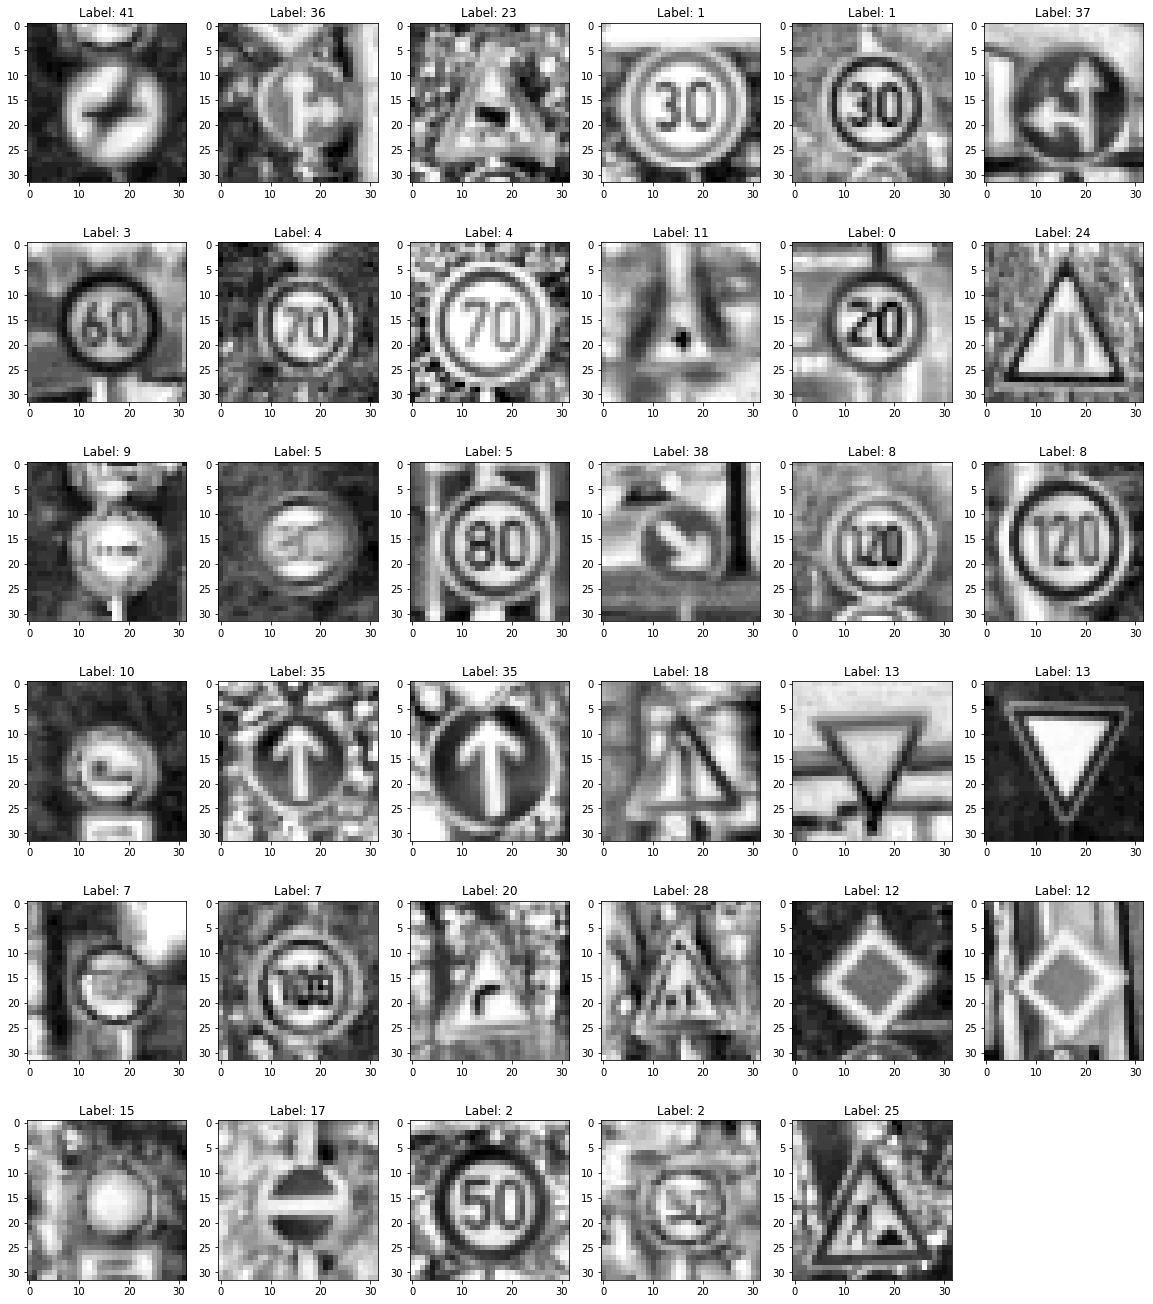

In [8]:
def grayscale(X):
    s = X.shape
    X_new = np.ndarray((s[0], s[1], s[2]), np.uint8)
    for i in range(len(X)):
        X_new[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        
    return X_new

def lumin_correct(X):
    s = X.shape
    X_new = np.ndarray((s[0], s[1], s[2], s[3]), np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4,4))
    for i in range(len(X)):
        X_new[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2YUV)
        X_new[i,:,:,0] = clahe.apply(X_new[i,:,:,0])
        #X_new[i,:,:,0] = cv2.equalizeHist(X_new[i,:,:,0])
        X_new[i] = cv2.cvtColor(X_new[i], cv2.COLOR_YUV2RGB) # could go straight to grayscale from here...
    return X_new


def rshp(X):
    return X.reshape(X.shape + (1,))


def process_img(X):
    
    X = lumin_correct(X)
    X = grayscale(X)
    
    return X

X_train_proc = process_img(X_train_aug)
X_valid_proc = process_img(X_valid_raw)
X_test_proc = process_img(X_test_raw)


plot_imgs(X_train_proc[test_img_labels], y_train_raw[test_img_labels], cmap = 'gray')

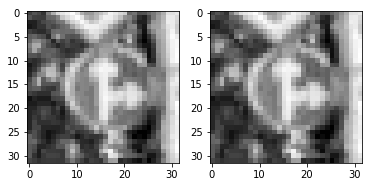

In [9]:
# Normalize and reshape

def normalize(X):
    X = (np.float32(X)-128.0)/128.0
    return X

X_train = normalize(X_train_proc)
X_valid = normalize(X_valid_proc)
X_test = normalize(X_test_proc)

# Plot test figures
plt.subplot(121)
plt.imshow(X_train_proc[1000], cmap='gray')
plt.subplot(122)
plt.imshow(X_train[1000], cmap='gray')



In [10]:
# Set up training data
# The image processing pipeline convered images to 32x32; need to add another dimension for TF.
X_train = rshp(X_train)
X_valid = rshp(X_valid)
X_test = rshp(X_test)

y_train = y_train_aug
y_valid = y_valid_raw
y_test = y_test_raw

### Model Architecture

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


# Helper function to create a fully connected layer
def conctdLayer(x, mu, sigma, in_dim, out_dim):
    w = tf.Variable(tf.truncated_normal([in_dim, out_dim], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros([out_dim]))
    x1 = tf.add(tf.matmul(x, w), b)
   
    return x1


# Helper function to create a convolution layer
def convLayer(x, mu, sigma, fsize, stride, pad, keep):
    w = tf.Variable(tf.truncated_normal(fsize, mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(fsize[3]))
    
    x1 = tf.nn.conv2d(x, w, strides=[1,stride,stride,1], padding = pad)
    x1 = tf.nn.bias_add(x1, b)

    x1 = tf.nn.relu(x1)
    x1 = tf.nn.dropout(x1, keep)
    
    return x1


# Covnet
def covnet(x):
    mu = 0
    sigma = 0.1
    
    # Convolution -> 32x32 to 28x28
    x = convLayer(x, mu, sigma, [5, 5, 1, 10], 1, 'VALID', keep[0])
    print("After conv 1",x.get_shape())
    
    
    # Max pool -> 28x28 to 14x14
    x1 = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    print("After maxpool 1",x1.get_shape())
    
    # Convolution -> 14x14 to 10x10
    x2 = convLayer(x1, mu, sigma, [5, 5, 10, 20], 1, 'VALID', keep[1])
    print("After conv 2:",x2.get_shape())
    
    # Max pool -> 10x10 to 5x5
    x2 = tf.nn.max_pool(x2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    print("After maxpool 3:",x2.get_shape())
    
    x3 = convLayer(x2, mu, sigma, [5, 5, 20, 500], 1, 'VALID', keep[1])
    print("After conv 3:",x3.get_shape())
    
    # Flatten and concat -> 1x900
    x = tf.concat([tf.contrib.layers.flatten(x3), tf.contrib.layers.flatten(x1)], 1)
    print("After flatten:",x.get_shape())
    
    # Connected layer -> 900x120
    x = conctdLayer(x, mu, sigma, 2460, 120)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep[2])
    
    # Connected layer -> 3216x120
    x = conctdLayer(x, mu, sigma, 120, 84)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep[3])
    
    # Connected layer -> 120x43
    x = conctdLayer(x, mu, sigma, 84, 43)
    
    return x



### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [21]:
from sklearn.utils import shuffle


# Set up parameters for training
EPOCHS = 5
BATCH_SIZE = 128
LEARN_RATE = 0.0008


x = tf.placeholder(tf.float32, (None, img_shp[0], img_shp[1], 1))
y = tf.placeholder(tf.float32, (None))
keep = tf.placeholder(tf.float32, 4)
one_hot_y = tf.one_hot(tf.cast(y, tf.int32), tf.cast(n_class, tf.int32))


logits = covnet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Helper function for evaluating accruacy
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep: (1.0, 1.0, 1.0, 1.0)})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Variables for plotting a learning curve across epochs
training_accuracy = np.zeros(EPOCHS)
validation_accuracy = np.zeros(EPOCHS)


# Start the session and train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep: (1.0, 1.0, 0.5, 1.0)})
        
        training_accuracy[i] = evaluate(X_train, y_train)
        validation_accuracy[i] = evaluate(X_valid, y_valid)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy[i]))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
        print()
        
    saver.save(sess, './lenet')
    
    print("Model saved")

After conv 1 (?, 28, 28, 10)
After maxpool 1 (?, 14, 14, 10)
After conv 2: (?, 10, 10, 20)
After maxpool 3: (?, 5, 5, 20)
After conv 3: (?, 1, 1, 500)
After flatten: (?, 2460)
Training...

EPOCH 1 ...
Training Accuracy = 0.943
Validation Accuracy = 0.919

EPOCH 2 ...
Training Accuracy = 0.981
Validation Accuracy = 0.935

EPOCH 3 ...
Training Accuracy = 0.990
Validation Accuracy = 0.959

EPOCH 4 ...
Training Accuracy = 0.995
Validation Accuracy = 0.963

EPOCH 5 ...
Training Accuracy = 0.995
Validation Accuracy = 0.963

Model saved


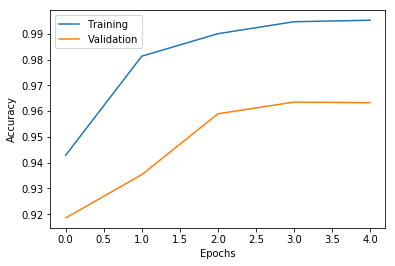

In [22]:
# Plot training curve
plt.figure()

plt.plot(training_accuracy)
plt.plot(validation_accuracy)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

In [23]:
# Check test accuracy
with tf.Session() as sess:
##sess = tf.get_default_session()
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")

    test_accuracy = evaluate(X_test, y_test)
print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.951


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

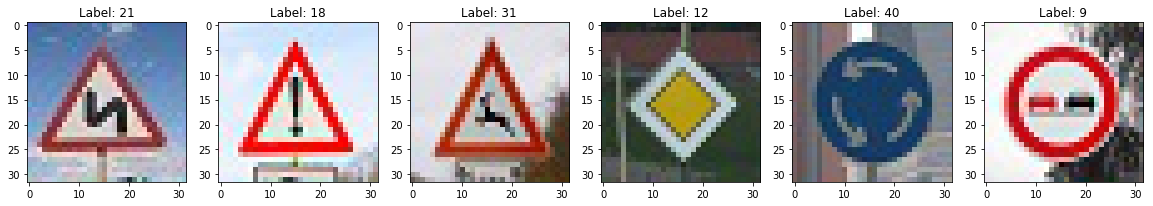

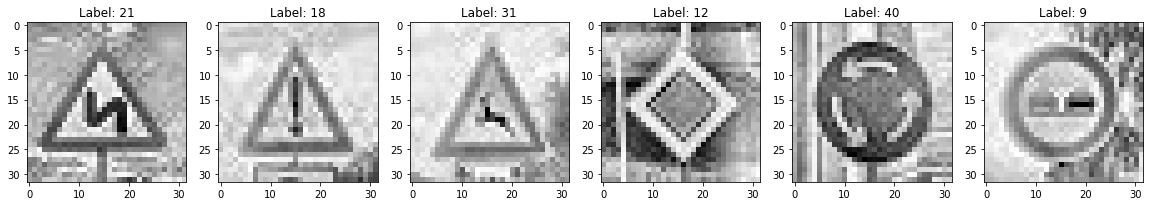

In [24]:
import glob

img_files = glob.glob('my_imgs/sign*.jpg')

my_labels = np.array([21, 18, 31, 12, 40, 9])
my_imgs_raw = []
for file in img_files:
    my_imgs_raw.append(plt.imread(file))

my_imgs_raw = np.array(my_imgs_raw)
plot_imgs(my_imgs_raw, my_labels)

my_imgs = process_img(my_imgs_raw)
my_imgs = normalize(my_imgs)

plot_imgs(my_imgs, my_labels, cmap = 'gray')

my_imgs = rshp(my_imgs)


### Predict the Sign Type for Each Image and Output Top 5 Softmax Probabilities 

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [25]:
my_softmax = tf.nn.softmax(logits)
my_top_k = tf.nn.top_k(my_softmax, k=5)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer());
    saver3 = tf.train.import_meta_graph('./lenet.meta');
    saver3.restore(sess, "./lenet");
    
    my_img_prob = sess.run(my_softmax, feed_dict={x: my_imgs, keep: (1.0, 1.0, 1.0, 1.0)})
    my_top_k = sess.run(my_top_k, feed_dict={x: my_imgs, keep: (1.0, 1.0, 1.0, 1.0)})
    
    my_acc = evaluate(my_imgs, my_labels)

    
    print("Accuracy for my images: {:.3f}".format(my_acc))


INFO:tensorflow:Restoring parameters from ./lenet
Accuracy for my images: 0.833


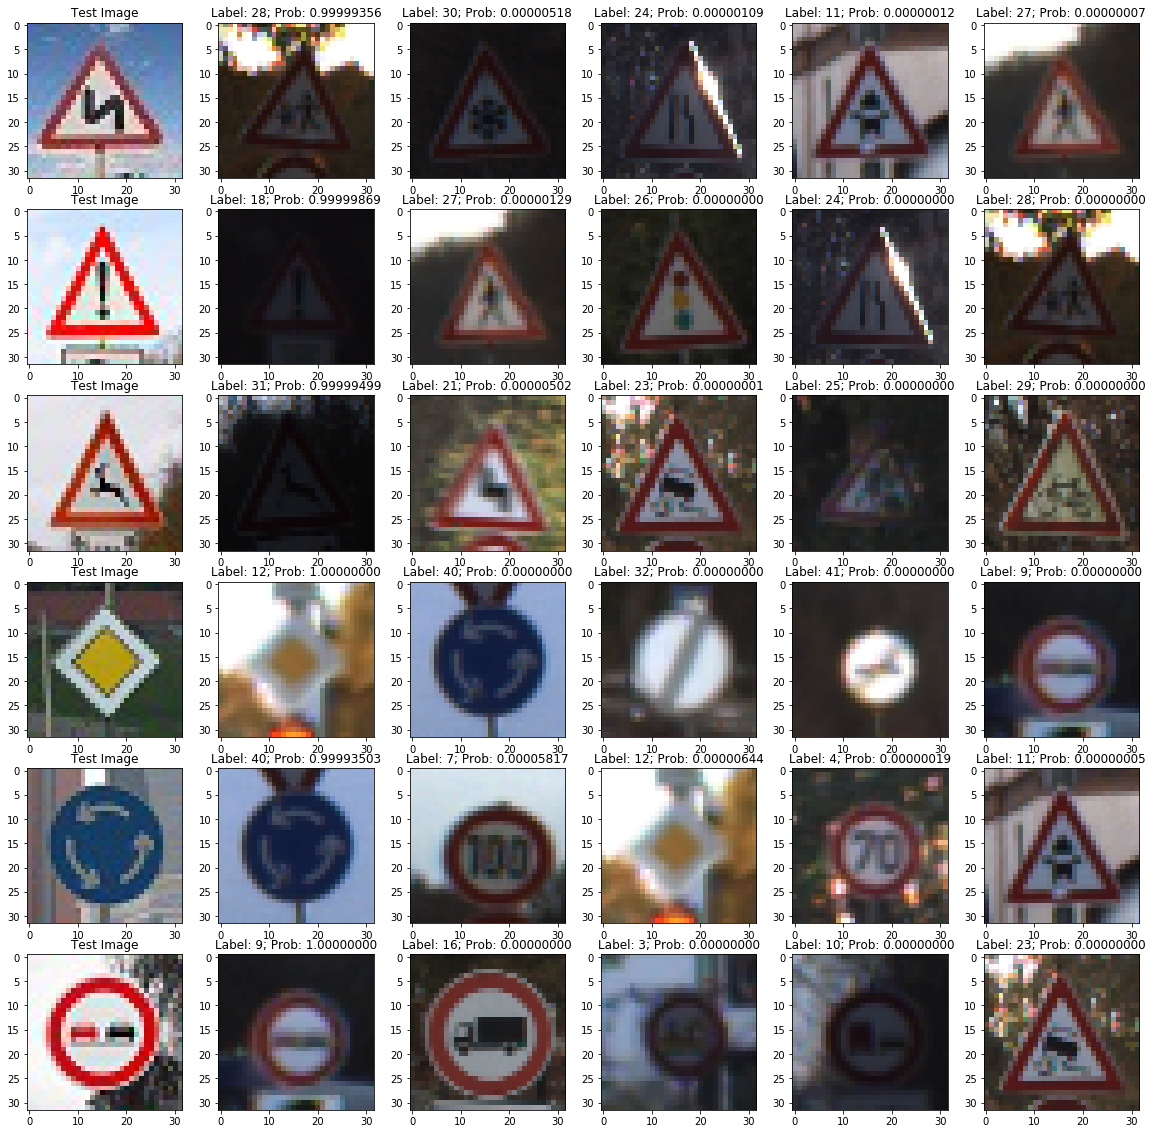

In [26]:
ind = np.array(my_top_k.indices)
prob = np.array(my_top_k.values)

rows = ind.shape[0]
cols = ind.shape[1]

plt.figure(figsize=(20,20))
plotNum = 1;
for i in range(rows):
    plt.subplot(rows, cols+1, plotNum)
    plt.imshow(my_imgs_raw[i])
    plt.title("Test Image")
    plotNum = plotNum + 1
    for j in range(cols):
        img_idx = ind[i,j]
        img_prob = prob[i,j]
        ex_img = X_test_raw[y_test_raw == img_idx][10] ## pick an image from the test set... 
        plt.subplot(rows, cols+1, plotNum)
        plt.imshow(ex_img)
        plt.title("Label: {:d}; Prob: {:.8f}".format(img_idx, img_prob))
        plotNum = plotNum + 1
        


### Analysis of Incorrect "Double Curve" Classification###
The classifier was unable to classify the double curve sign correctly. The originial image i selected from the web was actually flipped 180 degrees at first (i.e.: double curve to the right). Looking at the training set (shown below), it appears as if the only included samples have a "double curve to the left". I assumed that flipping the image by 180 degrees would then result in a correct classification; however, the classifier still failed, classifying the sign as "children crossing". It appears thie is because the sign I selected is a slight variant of the sign in the training set. Note that the signs in the training set have a shorter middle siection, such that the two vertical sections of the "double curve" are closer together. This is an interesting in that it demonstrates potential issues with NNs, and the importance of having a varied training set.

NOTE: it's also apparent that the training set contained a rather small number of variations of the sign in quetion (i.e.: the samples were derived from a small number of "passes" of the "double curve" sign; I assume that a more varied training set may have improved the outcome.

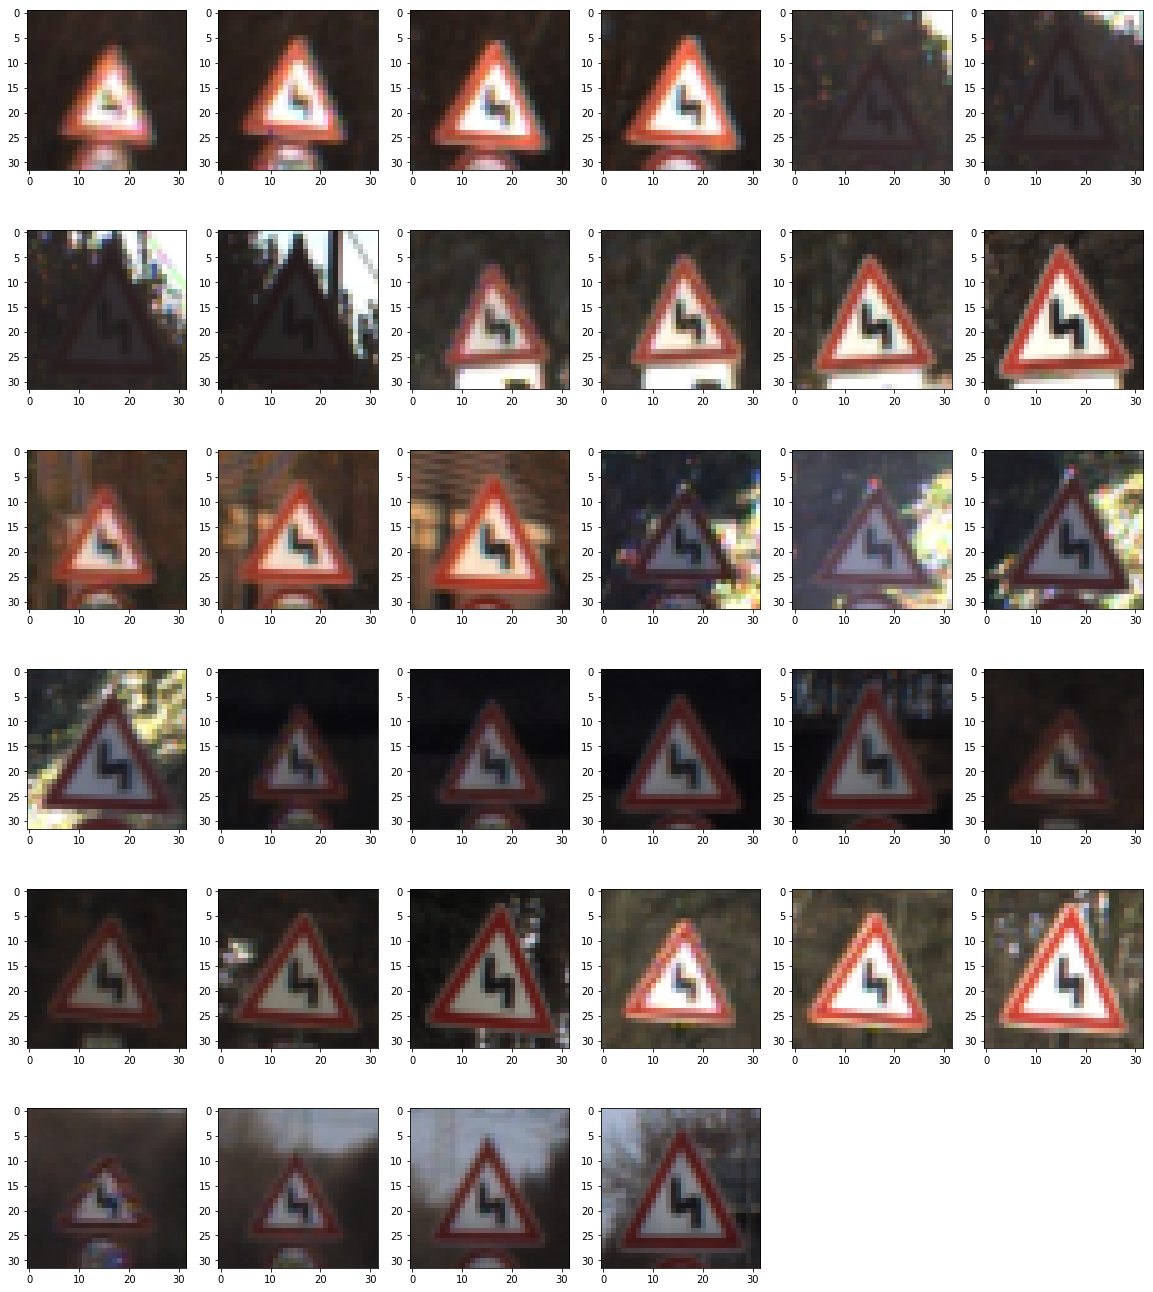

In [27]:
imgs21 = X_train_raw[y_train_raw == 21][np.arange(0,270,8)]
plot_imgs(imgs21)